## DATA 608 Assignment #2
**Sie Siong Wong** \
**02/25/2021**

In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy

from pyproj import Transformer
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

# from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv('C:\\Users\\wongs34\\Documents\School\\DATA 608\\Assignments\\Assignment 2\\nyc_pluto_20v8_csv\\pluto_20v8.csv')


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

C:\Users\wongs34\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning:

Columns (18,19,20,21,22,23,24,26,63,76,79,86) have mixed types.Specify dtype option on import or set low_memory=False.



I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:
# wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
# nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
# ny['xcoord'] = 0.3048*ny['xcoord']
# ny['ycoord'] = 0.3048*ny['ycoord']
# ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

# ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig.show()

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

### Answer

We can use the simple moving average to deal with those spike between 1899 and 1985 periods. To do this, I use the the rolling method to do 5 years moving average starting from 1885 to 1985.

Data preprocessing and transformation:

In [6]:
# Slice rows for year between 1885 and 1985
pd.options.mode.chained_assignment = None
nyc = ny[['numfloors','yearbuilt']]
nyc['numfloors'] = round(nyc['numfloors']).astype('int64')
nyc['yearbuilt'] = pd.to_datetime(nyc['yearbuilt'], format='%Y').dt.year
nyc_2 = nyc[(nyc.yearbuilt >= 1885) & (nyc.yearbuilt <= 1985)]
nyc_3 = nyc.drop(nyc[(nyc.yearbuilt >= 1885) & (nyc.yearbuilt <= 1985)].index)
print(f"{'Maximum Floor: '}{np.max(nyc['numfloors'])}")
print(f"{'Maximum Floor: '}{np.min(nyc['numfloors'])}")

Maximum Floor: 104
Maximum Floor: 0


Now we can group the building floor into every 10 floor up to 110 floor as the maximum floor is 104.

In [7]:
# Group by floor range between year 1885-1985
ranges = [0,10,20,30,40,50,60,70,80,90,100,110]
labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110']
nyc_2['range'] = pd.cut(nyc_2['numfloors'],ranges, labels=labels, include_lowest=True)
bldg_floor_group_1 = nyc_2.groupby(['range','yearbuilt']).size().reset_index(name='counts')
bldg_floor_group_1['count_mavg'] = round(bldg_floor_group_1['counts'].rolling(5, min_periods=1).mean()).astype('int64')
bldg_floor_group_1 = bldg_floor_group_1.drop(columns=['counts'])
bldg_floor_group_1.rename(columns = {'count_mavg':'counts'}, inplace=True)
bldg_floor_group_1.head()


range  yearbuilt  counts
0  0-10       1885     498
1  0-10       1886     580
2  0-10       1887     591
3  0-10       1888     564
4  0-10       1889     612

In [8]:
# Group by floor range other than years between 1910-1985
ranges = [0,10,20,30,40,50,60,70,80,90,100,110]
labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110']
nyc_3['range'] = pd.cut(nyc_3['numfloors'],ranges, labels=labels, include_lowest=True)
bldg_floor_group_2 = nyc_3.groupby(['range','yearbuilt']).size().reset_index(name='counts')
bldg_floor_group_2.head()

range  yearbuilt  counts
0  0-10       1851      89
1  0-10       1852     209
2  0-10       1853     245
3  0-10       1854     239
4  0-10       1855     268

In [9]:
# Concanate bldg_floor_group_1 and bldg_floor_group_2
bldg_floor_group = pd.concat([bldg_floor_group_1, bldg_floor_group_2])
bldg_floor_group

range  yearbuilt  counts
0       0-10       1885     498
1       0-10       1886     580
2       0-10       1887     591
3       0-10       1888     564
4       0-10       1889     612
..       ...        ...     ...
743  100-110       2015       0
744  100-110       2016       0
745  100-110       2017       0
746  100-110       2018       0
747  100-110       2019       0

[1859 rows x 3 columns]

In [10]:
# Check the total number building for each floor range
bldg_floor_group_total = bldg_floor_group.groupby(['range']).sum(['counts']).drop(['yearbuilt'], axis=1)
bldg_floor_group_total

counts
range          
0-10     801871
10-20      8270
20-30       856
30-40       428
40-50       206
50-60        71
60-70        24
70-80        12
80-90         5
90-100        0
100-110       1

We can see that the 90-100 floor range has zero building built. We can drop the 90-100 floor range rows for better small multiple charts visualization.

In [11]:
# Drop the 90-100 floor range rows
bldg_floor_group = bldg_floor_group[bldg_floor_group['range']!='90-100']
bldg_floor_group

range  yearbuilt  counts
0       0-10       1885     498
1       0-10       1886     580
2       0-10       1887     591
3       0-10       1888     564
4       0-10       1889     612
..       ...        ...     ...
743  100-110       2015       0
744  100-110       2016       0
745  100-110       2017       0
746  100-110       2018       0
747  100-110       2019       0

[1690 rows x 3 columns]

Plot small multiple area charts to show how many buildings of a certain number of floors were built in each year and using the log scale for the y-axis.

In [12]:
import plotly.express as px
fig = px.area(bldg_floor_group, x='yearbuilt', y='counts', 
              facet_col="range", facet_col_wrap=2, log_y=True, color='range', 
              title ='<b>NYC Number of Buildings Built on Floor Range Between Years 1850-2019</b>',
              labels={'yearbuilt':'Year Built', 'counts':''})
fig.update_layout(showlegend=False, title_x=0.5)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("range=0-10", "0-10 Story")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("range=10-20", "10-20 Story")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("range=", "")))
fig['layout']['yaxis5']['title']['text']='Number of Building (log10)'
fig.show()

From my point of view, it makes sense to me to bin buildings into floor range like I did above. It's a very useful technique to group a number of more or less continuous values into a smaller number of bins especially in this case where building floor is not continuous value. Even though buildings are getting built taller, but as you can see in the past 169 years, most of the buildings are below 50 floors. There is only one building, the "One World Trade Center", that has more than 100 floors built in 2009.

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [13]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

fig = go.FigureWidget(
    data = [
        go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
    ]
)

fig.show()

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



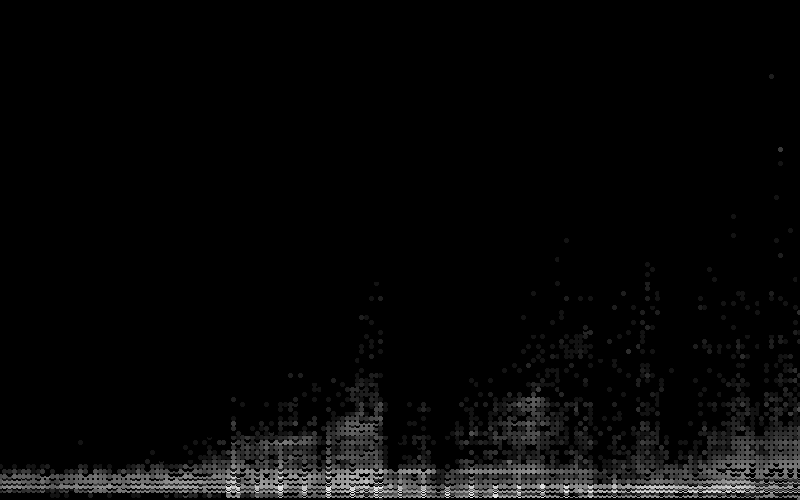

In [14]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

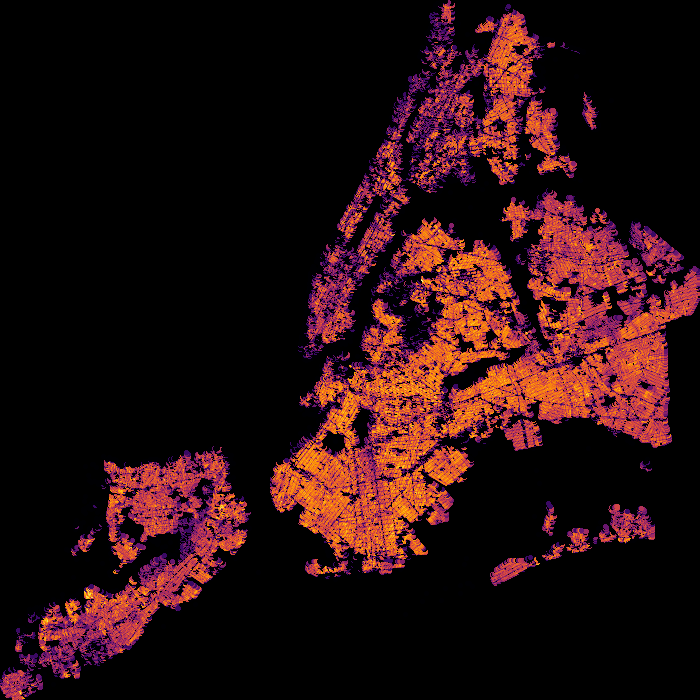

In [15]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

### Answer

In the dataset, we're given the assesed land value and total assessed value for each tax lot. To find out the assesed value of a building structure, we can deduct the total asssesed value from assessed land value.

In [16]:
# Slice only columns used for this question
pd.options.mode.chained_assignment = None
nyc_2 = ny[['assessland','assesstot', 'xcoord', 'ycoord']]
nyc_2.head()

assessland  assesstot    xcoord    ycoord
0     24900.0   171420.0  996992.0  234157.0
1     15960.0    72660.0  984030.0  159620.0
2     12900.0    74700.0  982473.0  158966.0
4      5460.0    60060.0  996091.0  164469.0
5    229950.0  1066500.0  997599.0  220113.0

In [17]:
# Calculate the building structure value
nyc_2['assesstructure'] = nyc_2['assesstot']-nyc_2['assessland']

In [18]:
# Data exploration
print(f"{'Assessed Land Mean Value: '}{round(np.mean(nyc_2['assessland']))}")
print(f"{'Assessed Land Median Value: '}{round(np.median(nyc_2['assessland']))}")
print(f"{'Assessed Building Mean Value: '}{round(np.mean(nyc_2['assesstructure']))}")
print(f"{'Assessed Building Median Value: '}{round(np.median(nyc_2['assesstructure']))}")

Assessed Land Mean Value: 110164
Assessed Land Median Value: 14160
Assessed Building Mean Value: 430822
Assessed Building Median Value: 38100


We can see that the mean and median value for both land and building value are much different. This indicates the data for both of these variables are heavily skewed. We can use the log transformation for both variables to reduce skewness.

In [20]:
# Replace value equal to 0 with 1 for log transformation
nyc_2['assessland'] = nyc_2['assessland'].replace(0.0, 1)
nyc_2['assesstructure'] = nyc_2['assesstructure'].replace(0.0, 1)

# Convert the assessland and assessstructure to log value
nyc_2['assessland'] = np.log10(nyc_2['assessland'])
nyc_2['assesstructure'] = np.log10(nyc_2['assesstructure'])

Because the datashader does not care about the units, we can directly use the x-y coordinates. Unless we want to overlay the datashader image on a web map, then we may need to convert the coordinates to some other units.

In [21]:
# Plot bivariate chloropleth map to visualize the underbuilt or overbuilt areas of the city
NewYorkCity   = ((913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
asl = cvs.points(nyc_2, 'xcoord', 'ycoord', ds.mean('assessland'))
ast = cvs.points(nyc_2, 'xcoord', 'ycoord', ds.mean('assesstructure'))
land_img = tf.shade(asl, cmap = cm(['gray','blue','darkblue']), how='eq_hist')
bldg_img = tf.shade(ast, cmap = cm(['gray','orange','darkred']), how='eq_hist')
img_add = tf.stack(land_img, bldg_img, how='add')

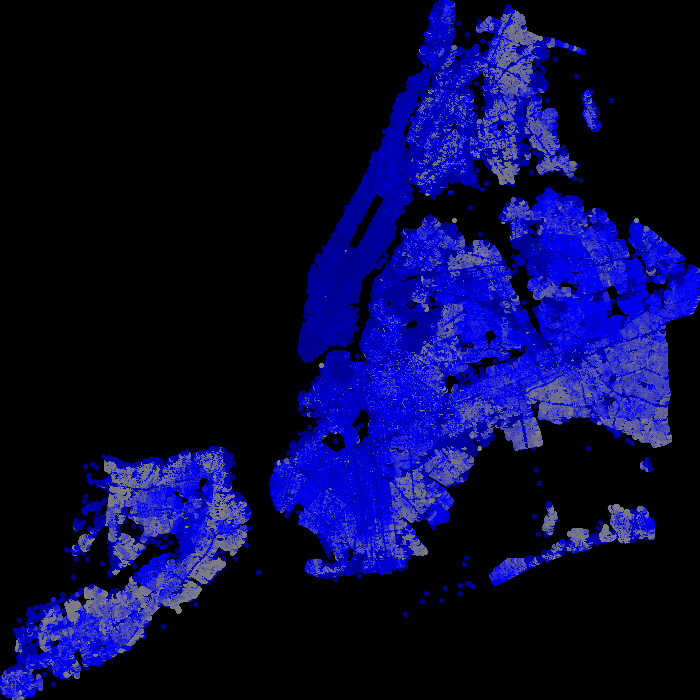

In [22]:
export(tf.spread(land_img, px=2), 'NYC Land Value Choropleth Map')

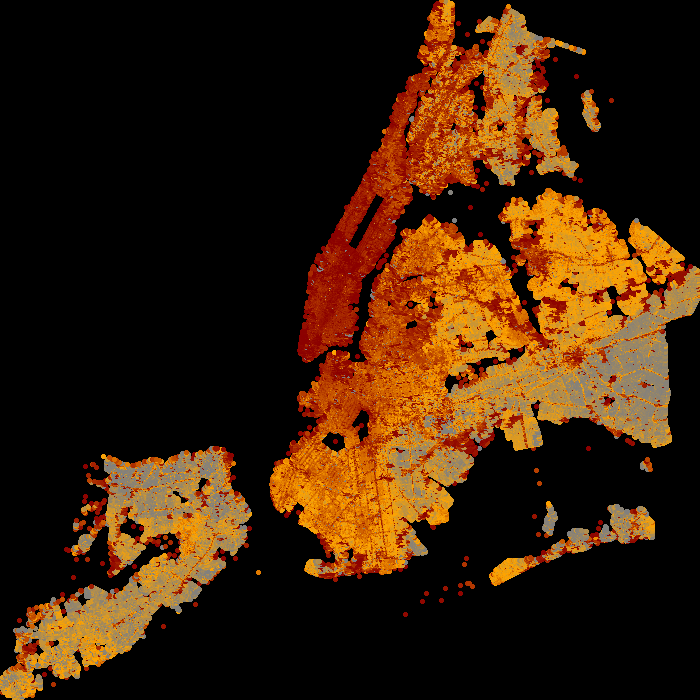

In [23]:
export(tf.spread(bldg_img, px=2), 'NYC Building Value Choropleth Map')

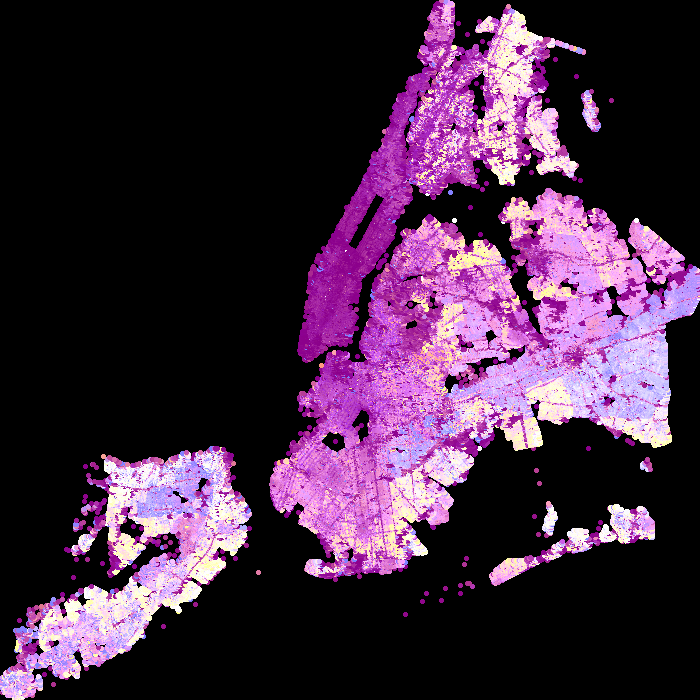

In [24]:
export(tf.spread(img_add, px=2), 'NYC Building & Land Value Bivariate Choropleth Map')

Stack both land and building chloropleth maps together, to produce the bivariate chloropleth map as shown above to visualize those underbuilt or overbuilt areas.

The areas with lower in land and building values are most in the outer boroughs like Jamaica, Staten Island, and Bronx colored with gray. These locations are such as South Jamaica, South Ozone Park, Rosedale, East Bronx, etc. We can see that areas like in Manhattan, Long Island city, Flushing, and areas next to the water are higher in land and buidling values and colored with mardi gras color (dark purple). All these locations are properly correlated with their land value.

Those areas in violet color are underbuilt (*land is more valuable than building*) and areas in pink color are overbuilt (*land is less valuable than building*). We can see from the map above that many underbuilt areas are in Jamaica borough and some in the Staten Island and Brooklyn boroughs such as West Brighton, Browsville, and East New York. Those overbuilt areas are mostly in Brooklyn and Queens and some in Staten Island but quite sparse. For instance, I can see from the map, Little Neck, where I live now is overbuilt. Furthermore, the darker the violet color are those severely underbuilt areas and the darker the pink color are those severely overbuilt areas.